# Import modules

In [14]:
# Imports
import time
import warnings
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub

# Geospatial / mapping
import folium
from folium import Choropleth
import branca.colormap as cm
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# NLP & text processing
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
nltk.download("vader_lexicon")

# Machine learning
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    HashingVectorizer,
    ENGLISH_STOP_WORDS,
)
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    roc_auc_score,
)
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

# Imaging utilities
from PIL import Image, ImageDraw



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# Retrieve Data

In [2]:
# retrieve data from kaggle
path = kagglehub.dataset_download("zynicide/wine-reviews")

# get data from two objects
df1 = pd.read_csv(path + "/winemag-data_first150k.csv", index_col=0)
df2 = pd.read_csv(path + "/winemag-data-130k-v2.csv", index_col=0)

# combine data frames and remove duplicates
df = pd.concat([df1, df2])
df = df.drop_duplicates()
df = df.reset_index(drop=True)

100%|██████████| 50.9M/50.9M [00:03<00:00, 16.3MB/s]

Extracting files...


# Exploratory Data Analysis

In [3]:
# view dataset general structure
df.head()

country                                        description  \
0      US  This tremendous 100% varietal wine hails from ...   
1   Spain  Ripe aromas of fig, blackberry and cassis are ...   
2      US  Mac Watson honors the memory of a wine once ma...   
3      US  This spent 20 months in 30% new French oak, an...   
4  France  This is the top wine from La Bégude, named aft...   

                            designation  points  price        province  \
0                     Martha's Vineyard      96  235.0      California   
1  Carodorum Selección Especial Reserva      96  110.0  Northern Spain   
2         Special Selected Late Harvest      96   90.0      California   
3                               Reserve      96   65.0          Oregon   
4                            La Brûlade      95   66.0        Provence   

            region_1           region_2             variety  \
0        Napa Valley               Napa  Cabernet Sauvignon   
1               Toro                NaN       Tinta de Toro   
2     Knights Valley             Sonoma     Sauvignon Blanc   
3  Willamette Valley  Willamette Valley          Pinot Noir   
4             Bandol                NaN  Provence red blend   

                    winery taster_name taster_twitter_handle title  
0                    Heitz         NaN                   NaN   NaN  
1  Bodega Carmen Rodríguez         NaN                   NaN   NaN  
2                 Macauley         NaN                   NaN   NaN  
3                    Ponzi         NaN                   NaN   NaN  
4     Domaine de la Bégude         NaN                   NaN   NaN

In [4]:
# view data frame object
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217839 entries, 0 to 217838
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                217777 non-null  object 
 1   description            217839 non-null  object 
 2   designation            153398 non-null  object 
 3   points                 217839 non-null  int64  
 4   price                  200724 non-null  float64
 5   province               217777 non-null  object 
 6   region_1               182347 non-null  object 
 7   region_2               86260 non-null   object 
 8   variety                217838 non-null  object 
 9   winery                 217839 non-null  object 
 10  taster_name            95071 non-null   object 
 11  taster_twitter_handle  90542 non-null   object 
 12  title                  119988 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 21.6+ MB


In [5]:
top_countries = df['country'].value_counts().head(10)
print(top_countries)

country
US           91001
France       34812
Italy        32790
Spain        11559
Portugal      8764
Chile         7919
Argentina     6991
Australia     5349
Austria       4993
Germany       3521
Name: count, dtype: int64


## Wines World Map

In [6]:
# set up data for world map

agg_data = df.groupby('country').agg({
    'variety': pd.Series.nunique,  # get num unqiue varieties by country
    'price': 'mean',              # calculate average price by country
    'country': 'size'             # num of wines by country

    # renaming

}).rename(columns={
    'variety': 'varieties',
    'price': 'avg_price',
    'country': 'total_wines'
}).reset_index()

# fix country naming inconsistency issues

name_map = {
    "US":   "United States of America",
    "USA":  "United States of America",
    "U.S.": "United States of America",
    "England":        "United Kingdom",
    "UK":             "United Kingdom",
    "Czech Republic": "Czechia",
    "Macedonia":      "North Macedonia",
    "South Korea":    "Republic of Korea",
}
agg_data["country"] = agg_data["country"].replace(name_map)

# gather info for plotting

min_wines = agg_data['total_wines'].min()
max_wines = agg_data['total_wines'].max()

color_scale = cm.linear.YlGnBu_09.scale(min_wines, max_wines)
color_scale.caption = "Number of wines reviewed"

agg_data.head()

country  varieties  avg_price  total_wines
0    Albania          1  20.000000            1
1  Argentina         76  22.922699         6991
2    Armenia          2  14.500000            2
3  Australia         87  33.300740         5349
4    Austria         62  31.240503         4993

In [7]:
# initialize geolocator
geolocator = Nominatim(user_agent="wine_map", timeout = 20)

# # troubleshooting geolocator
def geocode_with_retry(country, retries=3):
    for _ in range(retries):
        try:
            location = geolocator.geocode(country)
            if location:
                return location.latitude, location.longitude
            else:
                print(f"Could not geocode {country}")
                return None, None
        except GeocoderTimedOut:
            print(f"Timeout error for {country}. Retrying...")
            time.sleep(2)  # Wait before retrying
    print(f"Failed to geocode {country} after {retries} retries.")
    return None, None

# hardcoded coordinates for certain countries
hardcoded_coordinates = {
    'Lebanon': [33.8547, 35.8623],
    'Macedonia': [41.6086, 21.7453],
    'Armenia': [40.0691, 45.0382],
    'Albania': [41.1533, 20.1683],
    'Georgia': [42.3154, 43.3569]
}

def style_function(feature):
    country = feature["properties"]["name"]
    row = agg_data[agg_data["country"] == country]

    if not row.empty and row["total_wines"].iloc[0] > 0:
        # colour proportional to production
        fill = color_scale(row["total_wines"].iloc[0])
    else:
        fill = "#d3d3d3"                 # grey for no data / zero

    return {
        "fillColor":  fill,
        "color":      "black",           # border
        "weight":     0.5,
        "fillOpacity": 0.7,
    }

# create map
world_map = folium.Map(location=[20, 0], zoom_start=2)

folium.GeoJson(
    "https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json",
    style_function=style_function,
    name="Wines",
).add_to(world_map)

# attach legend
color_scale.add_to(world_map)

# loop through the countries to add markers and custom coordinates
for _, row in agg_data.iterrows():
    country = row['country']
    wine_count = row['total_wines']

    # check if the country has hardcoded coordinates
    if country in hardcoded_coordinates:
        lat, lon = hardcoded_coordinates[country]
    else:
        # if not, geocode the country to get coordinates
        lat, lon = geocode_with_retry(country)

    if lat and lon:
        # add a marker with the country details
        folium.Marker(
            location=[lat, lon],
            popup=f"{country}: {row['total_wines']} wines, Avg Price: ${row['avg_price']}, Varieties: {row['varieties']}",
        ).add_to(world_map)
    else:
        print(f"Skipping {country} due to failed geocoding.")

# save the map as an HTML file
world_map.save('wine_map.html')

world_map

## Wine Ratings

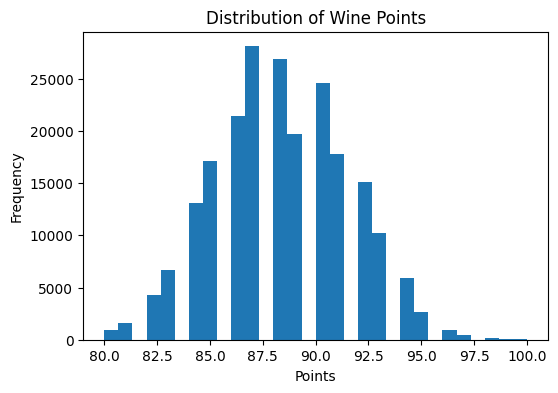

In [8]:
plt.figure(figsize=(6,4))
plt.hist(df['points'].dropna(), bins=30)
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.title('Distribution of Wine Points')
plt.show()

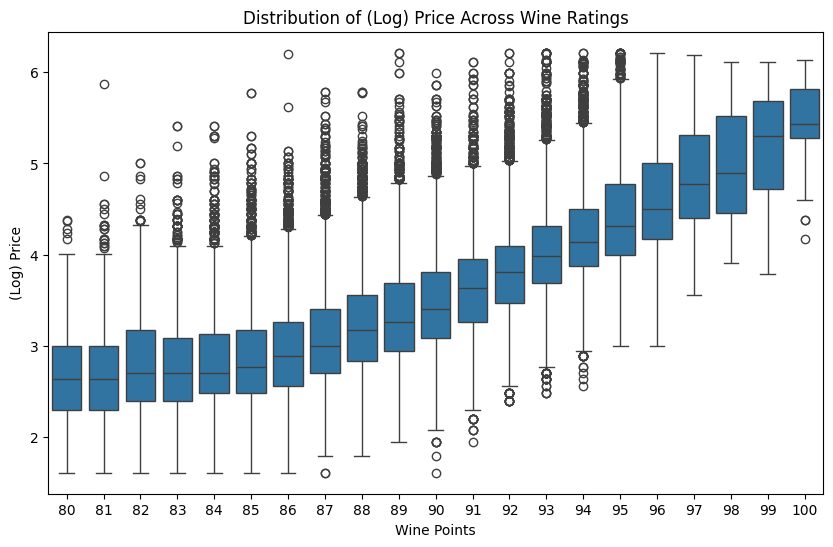

In [9]:
# plot relationship between review score and price of wine
df_filtered = df[df['price'].notnull() & df['price'].between(5, 500)]
plt.figure(figsize=(10, 6))
sns.boxplot(x='points', y=np.log(df_filtered['price']), data=df_filtered)
plt.title('Distribution of (Log) Price Across Wine Ratings')
plt.xlabel('Wine Points')
plt.ylabel('(Log) Price')
plt.show()

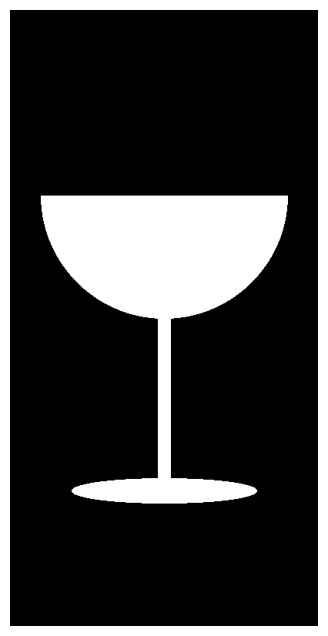

In [10]:
# glass mask for aesthetic world clouds

def create_glass_mask(w=400, h=800):
    # initalize
    m = Image.new("L", (w, h), 0)
    d = ImageDraw.Draw(m)

    # bowl of glass
    x0, y0 = w * 0.1, h * 0.1
    x1, y1 = w * 0.9, h * 0.5
    d.ellipse([(x0, y0), (x1, y1)], fill=255)
    y_cut = y0 + (y1 - y0) / 2
    d.rectangle([(0, 0), (w, y_cut)], fill=0)

    # stem
    stem_w, stem_h = w * 0.04, h * 0.3
    sx = (w - stem_w) / 2
    sy = y1
    d.rectangle([(sx, sy), (sx + stem_w, sy + stem_h)], fill=255)

    # base of glass
    x0, y0 = w * 0.1, h * 0.01
    x1, y1 = w * 0.7, h * 0.05
    d.ellipse([(x0+40, y0+600), (x1+40, y1+600)], fill=255)

    return np.array(m)

# inspect mask
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    mask = create_glass_mask(400, 800)
    plt.figure(figsize=(4,8))
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.show()

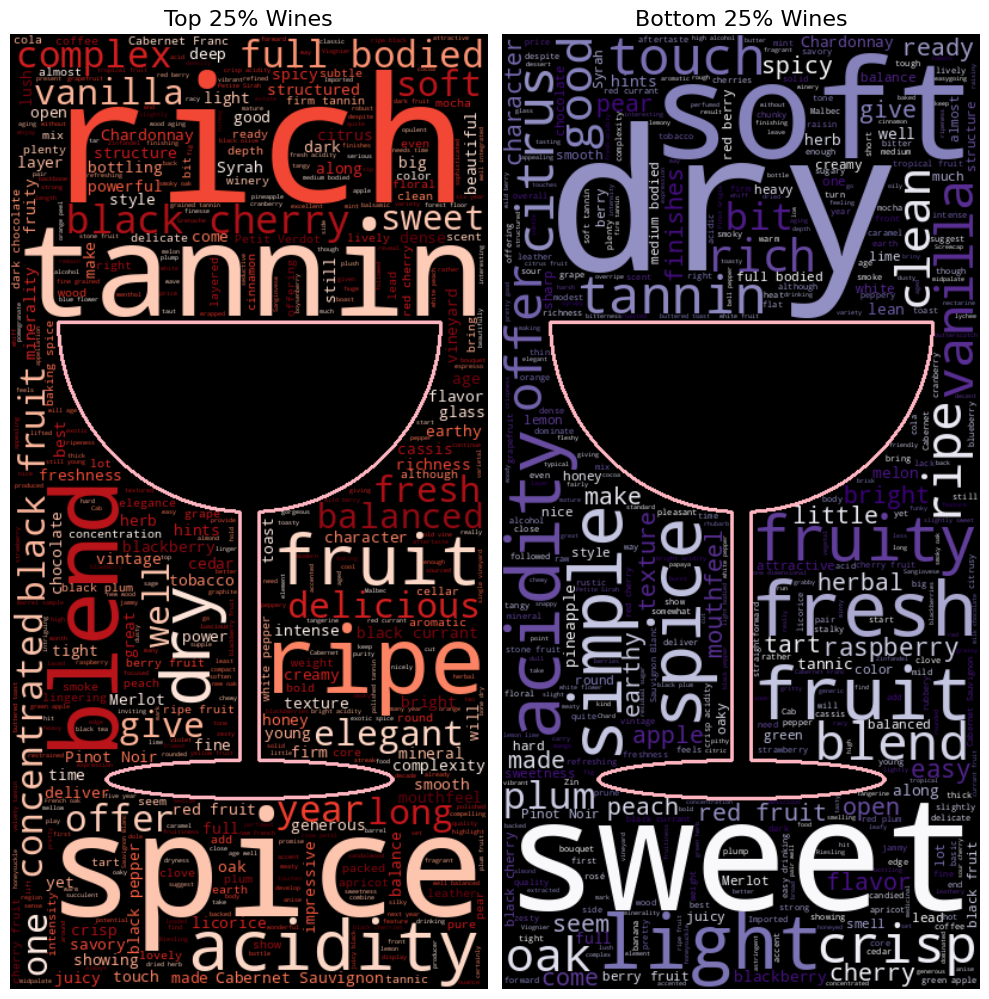

In [11]:
# create mask
mask = create_glass_mask(400, 800)

# create list of custom stopwords
custom_stopwords = STOPWORDS | {
    "wine", "wines", "flavors", "aroma", "palate", "note", "notes", "nose", "finish",
    "taste", "hint", "mouth", "feel", "tastes", "shows", "aromas", "theres", "drink", 'now'
}

# function to create word cloud given text data
def generate_wine_wordcloud(text_data, title, colormap='Reds'):
    text = " ".join(text_data.dropna())
    wc = WordCloud(
        width=mask.shape[1], height=mask.shape[0],
        background_color='black',
        mask=mask,
        contour_width=3, contour_color='#FFB6C1',
        colormap=colormap,
        stopwords=custom_stopwords,
        max_words=2000,
        random_state=42
    ).generate(text)
    return wc

# word clouds for top 25% and bottom 25% of wine scores
top_25 = df[df['points'] >= df['points'].quantile(0.75)]
bottom_25 = df[df['points'] <= df['points'].quantile(0.25)]

top_wc = generate_wine_wordcloud(top_25['description'], 'Top 25% Wines')
bottom_wc = generate_wine_wordcloud(bottom_25['description'], 'Bottom 25% Wines', colormap='Purples')

# plot side by side
plt.figure(figsize=(10, 10))

# top 25% wines
plt.subplot(1, 2, 1)
plt.imshow(top_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Top 25% Wines', fontsize=16)

# bottom 25% wines
plt.subplot(1, 2, 2)
plt.imshow(bottom_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Bottom 25% Wines', fontsize=16)

plt.tight_layout()
plt.show()


## Wine Prices

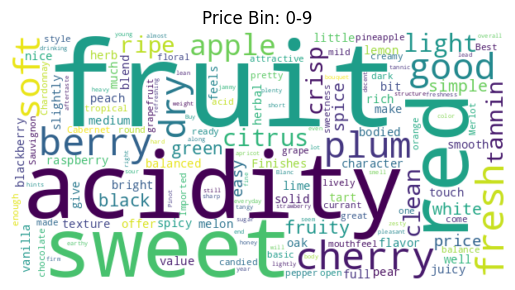

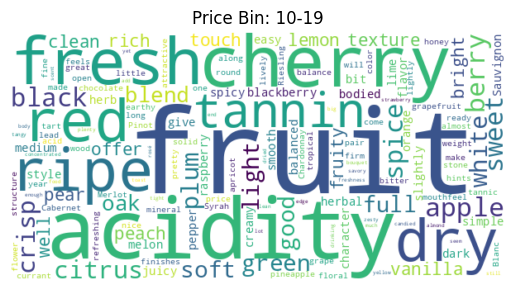

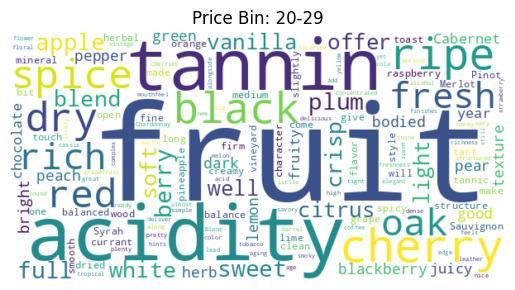

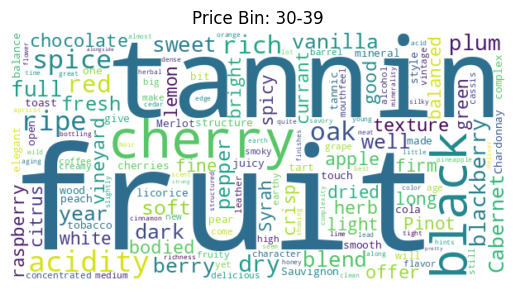

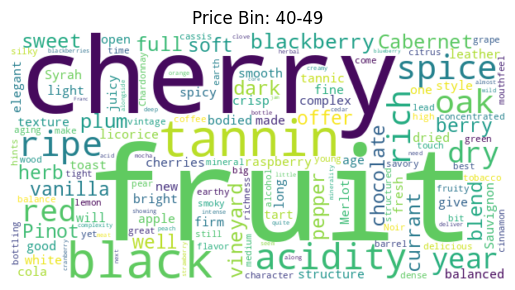

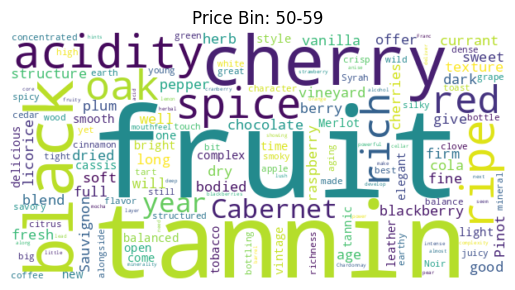

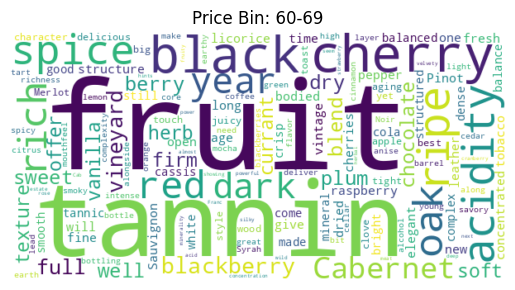

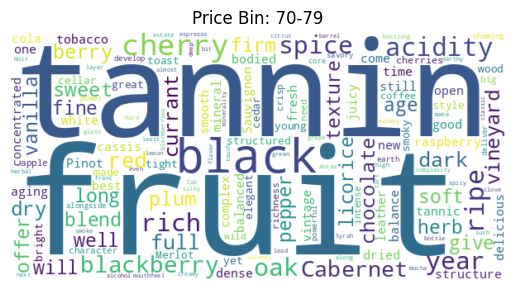

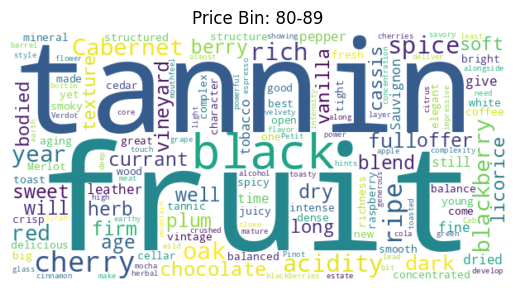

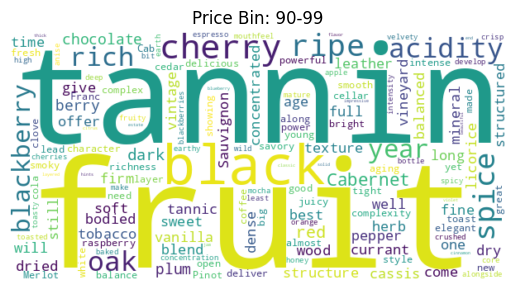

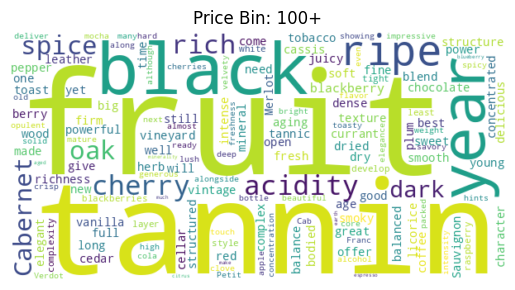

In [12]:
def generate_price_level_wordclouds(
    df,
    text_col='description',
    price_col='price_bin',
    additional_stopwords=None,
    *,
    wc_width=600,
    wc_height=300,
    max_words=150,
    step=10,
    high_bucket_label='100+'
):
    if text_col not in df.columns:
        raise KeyError(f"Column '{text_col}' missing.")
    if price_col not in df.columns and 'price' not in df.columns:
        raise KeyError(f"Neither '{price_col}' nor 'price' found.")
    if price_col not in df.columns:
        price_col = 'price'

    stopwords = STOPWORDS.union(w.lower() for w in (additional_stopwords or []))

    def _lower_bound(label):
        m = re.search(r'\d+', str(label))
        return int(m.group()) if m else float('inf')

    is_numeric = np.issubdtype(df[price_col].dtype, np.number)

    def _bucketize(v):
        val = v if is_numeric else _lower_bound(v)
        if pd.isna(val):
            return np.nan
        if val >= 100:
            return high_bucket_label
        lo = (int(val) // step) * step
        hi = lo + step - 1
        return f"{lo}-{hi}"

    df_clean = (
        df.dropna(subset=[price_col, text_col])
          .astype({text_col: str})
          .assign(_bucket=lambda d: d[price_col].apply(_bucketize))
          .dropna(subset=['_bucket'])
    )

    joined = df_clean.groupby('_bucket', sort=False)[text_col].agg(' '.join)

    def _order_key(lbl):
        return 1000 if lbl == high_bucket_label else int(lbl.split('-')[0])
    levels = sorted(joined.index, key=_order_key)

    for lvl in levels:
        wc = WordCloud(
            stopwords=stopwords,
            background_color='white',
            width=wc_width,
            height=wc_height,
            max_words=max_words,
            collocations=False
        ).generate(joined[lvl])

        plt.figure(figsize=(wc_width / 100, wc_height / 100))
        plt.imshow(wc, interpolation='bilinear')
        plt.title(f'Price Bin: {lvl}', fontsize=12, pad=6)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

generate_price_level_wordclouds(
    df,
    text_col='description',
    price_col='price_bin',
    additional_stopwords=custom_stopwords
)

#Sentiment Analysis#

## Sentiment and Wine Score##

In [15]:
# perform sentiment analysis on the reviews and correlate it with the wine score
sid = SentimentIntensityAnalyzer()
df['sentiment'] = df['description'].fillna('').apply(lambda x: sid.polarity_scores(x)['compound'])
print(df[['sentiment', 'points']].corr())

           sentiment    points
sentiment   1.000000  0.329027
points      0.329027  1.000000


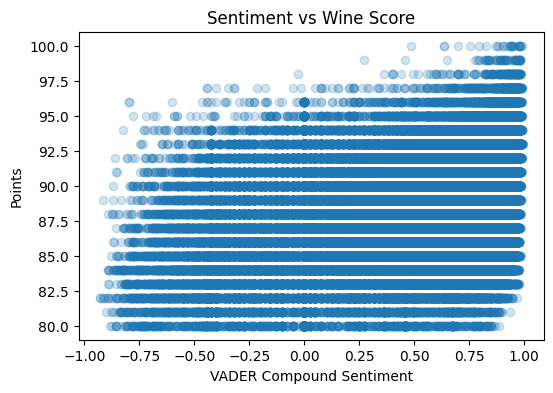

In [16]:
# plot the sentiment and wine score
plt.figure(figsize=(6,4))
plt.scatter(df['sentiment'], df['points'], alpha=0.2)
plt.xlabel('VADER Compound Sentiment')
plt.ylabel('Points')
plt.title('Sentiment vs Wine Score')
plt.show()

## Sentiment and Wine Price

   price_bin      mean  count       sem
0        0-9  0.496298   5956  0.005032
1      10-19  0.488873  62921  0.001527
2      20-29  0.510389  47420  0.001713
3      30-39  0.530656  28086  0.002197
4      40-49  0.544473  19448  0.002633
5      50-59  0.556477  12033  0.003309
6      60-69  0.567505   7958  0.004034
7      70-79  0.568560   5077  0.005140
8      80-89  0.583774   3022  0.006468
9      90-99  0.591390   2247  0.007478
10      100+  0.631814   6556  0.004301


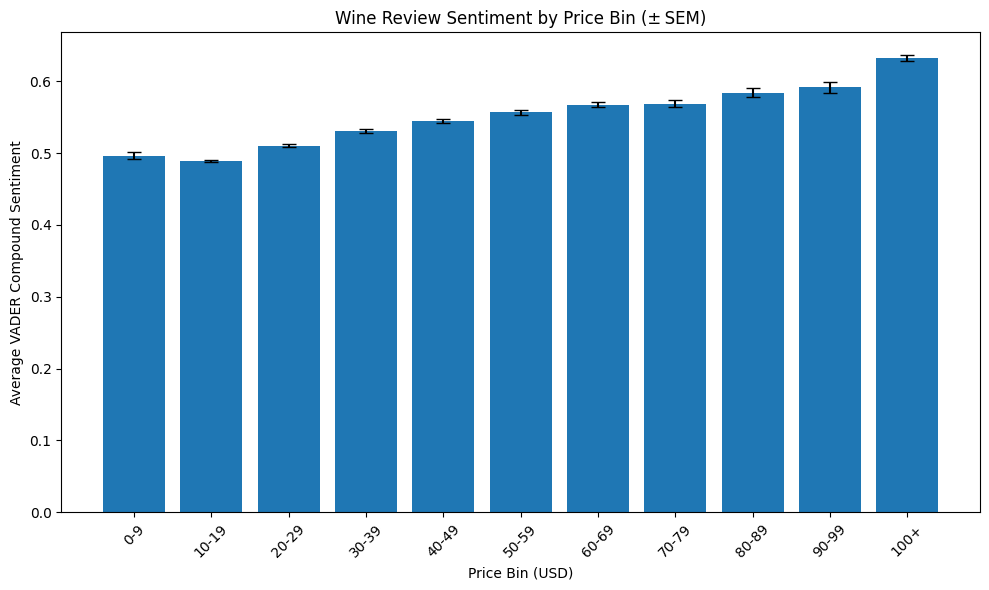

In [17]:
# create bins
if 'price_bin' not in df.columns:
    bins   = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]
    labels = [f'{lo}-{hi-1}' for lo, hi in zip(bins[:-2], bins[1:-1])] + ['100+']
    df['price_bin'] = pd.cut(df['price'], bins=bins, labels=labels, right=False)

# get stats per bin
stats = (
    df.dropna(subset=['price_bin', 'sentiment'])
      .groupby('price_bin', observed=True)['sentiment']
      .agg(mean='mean', count='count', std='std')
      .reset_index()
)
stats['sem'] = stats['std'] / np.sqrt(stats['count'])

print(stats[['price_bin', 'mean', 'count', 'sem']])

# plot
plt.figure(figsize=(10, 6))
plt.bar(stats['price_bin'], stats['mean'], yerr=stats['sem'], capsize=5)
plt.xticks(rotation=45)
plt.xlabel('Price Bin (USD)')
plt.ylabel('Average VADER Compound Sentiment')
plt.title('Wine Review Sentiment by Price Bin (± SEM)')
plt.tight_layout()
plt.show()


##Text Classification: Predict High‑Quality Wines (≥ 95 pts)




In [18]:
# text classification: predict high‑quality wines (≥ 95 pts)
df['label'] = (df['points'] >= 95).astype(int)

# split the data set
X_train, X_test, y_train, y_test = train_test_split(
    df['description'].fillna(''),
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=20000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

# train model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# predict
y_pred = clf.predict(X_test_tfidf)

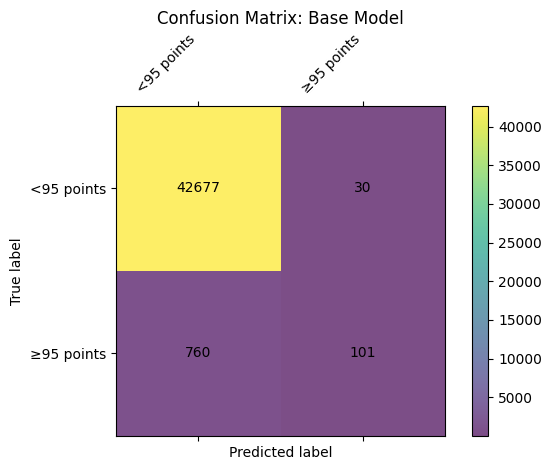

Accuracy: 0.9818674256334925
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     42707
           1       0.77      0.12      0.20       861

    accuracy                           0.98     43568
   macro avg       0.88      0.56      0.60     43568
weighted avg       0.98      0.98      0.98     43568



In [19]:
# create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# define the labels
labels = ['<95 points', '≥95 points']

# plot the confusion matrix nicely
fig, ax = plt.subplots()
cax = ax.matshow(cm, alpha=0.7)
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, f"{v}", ha='center', va='center')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix: Base Model')
fig.colorbar(cax)
plt.tight_layout()
plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [20]:
# check what are the top words corresponding to top and bottom wines
feature_names = np.array(vectorizer.get_feature_names_out())
coef = clf.coef_[0]

top_pos_idx = np.argsort(coef)[-20:][::-1]
top_neg_idx = np.argsort(coef)[:20]

print('Top words associated with high‑quality wines:')
print(feature_names[top_pos_idx])

print('\nTop words associated with lower‑quality wines:')
print(feature_names[top_neg_idx])

Top words associated with high‑quality wines:
['96' 'stunning' '97' '2030' 'superb' 'gorgeous' 'fabulous' 'beauty'
 'decades' 'immense' '2035' '2022' 'wonderful' 'extraordinary'
 'tremendous' 'huge' 'incredibly' 'amazing' '10' '2032']

Top words associated with lower‑quality wines:
['92' 'good' 'medium' 'soft' 'bit' 'flavors' '93' 'nice' 'fruity' 'easy'
 'aromas' 'light' 'little' 'offers' 'simple' 'bodied' 'dry' 'melon'
 'herbal' 'cherry']


In [21]:
# model tweaks

fast_pipe = Pipeline([
    ('hash', HashingVectorizer(
        n_features=2**18,
        alternate_sign=False,
        ngram_range=(1,2)
    )),
    ('clf', SGDClassifier(
        loss='log_loss',
        max_iter=1000,
        tol=1e-3,
        class_weight='balanced'
    ))
])

fast_pipe.fit(X_train, y_train)
y_pred = fast_pipe.predict(X_test)


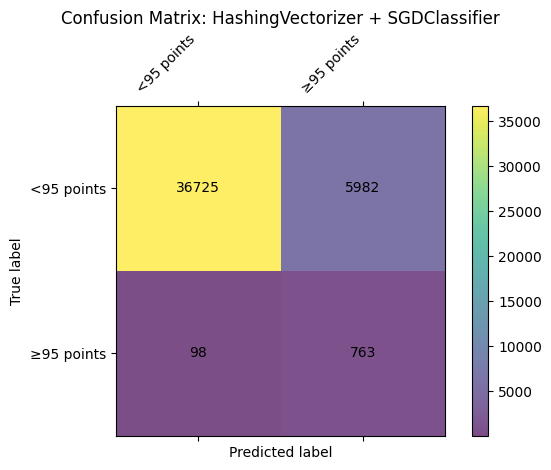

Accuracy: 0.8604480352552332
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     42707
           1       0.11      0.89      0.20       861

    accuracy                           0.86     43568
   macro avg       0.56      0.87      0.56     43568
weighted avg       0.98      0.86      0.91     43568



In [22]:
# create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# define the labels
labels = ['<95 points', '≥95 points']

# plot the confusion matrix nicely
fig, ax = plt.subplots()
cax = ax.matshow(cm, alpha=0.7)
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix: HashingVectorizer + SGDClassifier')
fig.colorbar(cax)
plt.tight_layout()
plt.show()


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

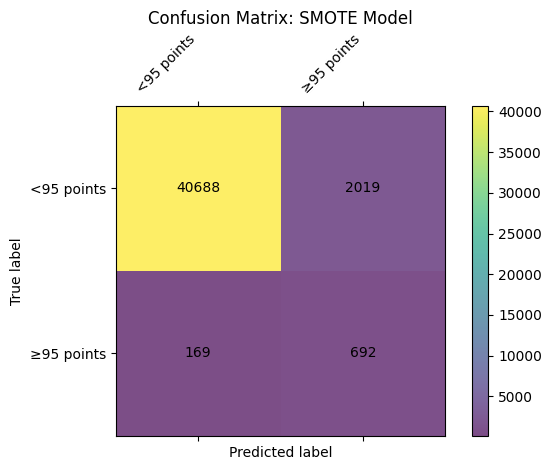

Accuracy: 0.9497796547925083
              precision    recall  f1-score   support

     <95 pts       1.00      0.95      0.97     42707
     ≥95 pts       0.26      0.80      0.39       861

    accuracy                           0.95     43568
   macro avg       0.63      0.88      0.68     43568
weighted avg       0.98      0.95      0.96     43568



In [23]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# resample the training set with SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_tfidf, y_train)

# train the balanced LogisticRegression
clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
clf.fit(X_res, y_res)

# evaluate on the held-out test set
y_smote_pred = clf.predict(X_test_tfidf)
y_smote_prob = clf.predict_proba(X_test_tfidf)[:, 1]

# create confusion matrix
cm = confusion_matrix(y_test, y_smote_pred)

# define the labels
labels = ['<95 points', '≥95 points']

# plot the confusion matrix nicely
fig, ax = plt.subplots()
cax = ax.matshow(cm, alpha=0.7)
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix: SMOTE Model')
fig.colorbar(cax)
plt.tight_layout()
plt.show()

print("Accuracy:", accuracy_score(y_test, y_smote_pred))
print(classification_report(y_test, y_smote_pred, target_names=['<95 pts','≥95 pts']))

In [24]:
# modify to boost performance

# numeric features extractor
num_feats = Pipeline([
    ('extract', FunctionTransformer(
        lambda texts: np.array([len(t) for t in texts]).reshape(-1,1)
    )),
    ('scale', StandardScaler())
])

# combine text & numeric
preprocessor = FeatureUnion([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=5)),
    ('length', num_feats)
])

pipe = Pipeline([
    ('feats', preprocessor),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('tfidf',
                                                 TfidfVectorizer(min_df=5,
                                                                 ngram_range=(1,
                                                                              2))),
                                                ('length',
                                                 Pipeline(steps=[('extract',
                                                                  FunctionTransformer(func=<function <lambda> at 0x7ac83226c5e0>)),
                                                                 ('scale',
                                                                  StandardScaler())]))])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [25]:
probs = pipe.predict_proba(X_test)[:,1]

# try threshold = 0.6
y_pred_th = (probs >= 0.6).astype(int)
print(confusion_matrix(y_test, y_pred_th))


[[41627  1080]
 [  187   674]]


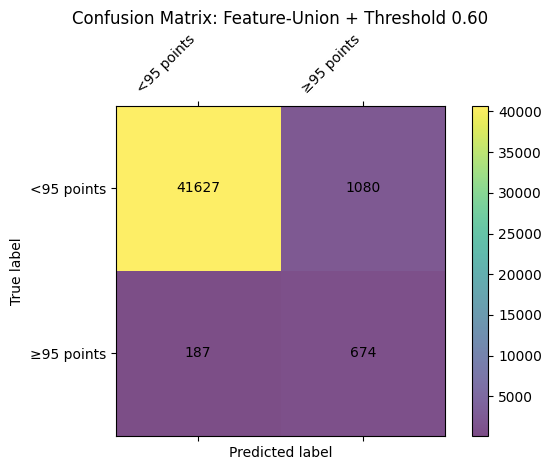

Accuracy: 0.9709190231362468
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     42707
           1       0.38      0.78      0.52       861

    accuracy                           0.97     43568
   macro avg       0.69      0.88      0.75     43568
weighted avg       0.98      0.97      0.98     43568



In [26]:
# plot results
fig, ax = plt.subplots()
cax = ax.matshow(cm, alpha=0.7)    # default colormap
for (i, j), v in np.ndenumerate(confusion_matrix(y_test, y_pred_th)):
    ax.text(j, i, str(v), ha='center', va='center')

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix: Feature-Union + Threshold 0.60')
fig.colorbar(cax)
plt.tight_layout()
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred_th))
print(classification_report(y_test, y_pred_th))

# Predict Wine Score

In [27]:
# set up features
y = df['points']
X = df['description'].fillna('')

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [28]:
# build TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 3),
    min_df=3,
    max_features=50_000,
    dtype=np.float32
)

# fit and transform
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

In [29]:
# initalize and fit the model
reg = LinearRegression()
reg.fit(X_train_vec, y_train)

# predict
pred = reg.predict(X_test_vec)

# compute error metrics
mae  = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred) ** 0.5

print("MAE :", mae)
print("RMSE:", rmse)

MAE : 1.355676531791687
RMSE: 1.7359904421090555


In [30]:
# get wine score from a description
def rate_wine(description: str) -> float:
    vec = vectorizer.transform([description])
    return float(reg.predict(vec)[0])

# example wine
print(rate_wine("Rich aromas of black cherry, cedar and tobacco with silky tannins."))


85.99813079833984


MAE  : 1.041
RMSE : 1.346


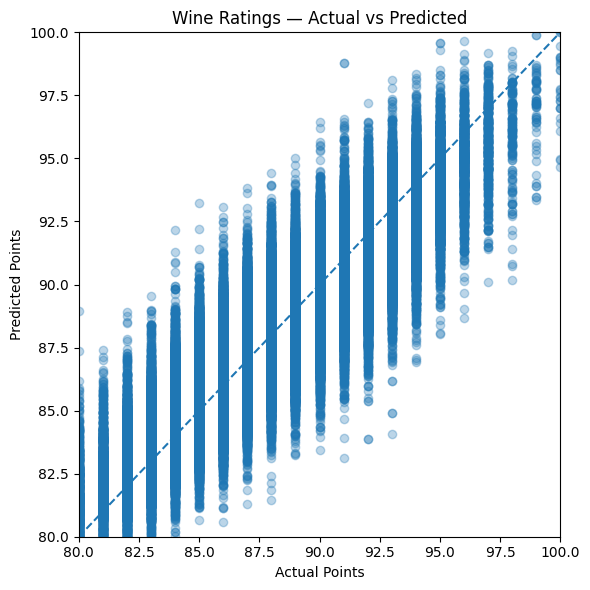

In [31]:
# vectorise and predict
X_all_vec = vectorizer.transform(df['description'].fillna(''))
df['predicted_points'] = reg.predict(X_all_vec)

# get residuals
df['error'] = df['predicted_points'] - df['points']

# get metrics
mae  = mean_absolute_error(df['points'], df['predicted_points'])
rmse = mean_squared_error(df['points'], df['predicted_points']) ** 0.5
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")

# plot graph
plt.figure(figsize=(6, 6))
plt.scatter(df['points'], df['predicted_points'], alpha=0.3)
plt.plot([80, 100], [80, 100], linestyle='--')      # identity line
plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")
plt.title("Wine Ratings — Actual vs Predicted")
plt.xlim(80, 100); plt.ylim(80, 100)
plt.tight_layout()
plt.show()

# Predict Wine Variety using Structured & Unstructured Features

In [32]:
# predict wine variety using structured & unstructured features


# drop rows with missing target
pred_df = df.drop(columns=['taster_name',	'taster_twitter_handle',	'title',	'sentiment',	'label', 'predicted_points',	'error'])
pred_df = pred_df.dropna(inplace = False)


# split features and target
X = pred_df.drop(columns=['variety'])
y = pred_df['variety']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define feature categories
text_features = 'description'
numeric_features = ['points', 'price']
categorical_features = ['country', 'province', 'region_1', 'region_2', 'designation', 'winery']

# preprocessing pipelines
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english'))
])

numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combine preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('text', text_pipeline, text_features),
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# full pipeline with classifier
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# fit model
model_pipeline.fit(X_train, y_train)

# predict
y_pred = model_pipeline.predict(X_test)

# evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7815900315900316
                                   precision    recall  f1-score   support

                        Aglianico       0.00      0.00      0.00         2
                         Albariño       1.00      0.38      0.55        16
                Alicante Bouschet       0.00      0.00      0.00         3
                       Alvarelhão       0.00      0.00      0.00         1
                           Arneis       0.00      0.00      0.00         1
                        Auxerrois       1.00      0.67      0.80         3
                        Baco Noir       1.00      0.33      0.50         3
                          Barbera       1.00      0.38      0.55        47
                     Black Muscat       0.00      0.00      0.00         1
                    Blaufränkisch       1.00      1.00      1.00         2
         Bordeaux-style Red Blend       0.80      0.76      0.78       499
       Bordeaux-style White Blend       1.00      0.67      0.80      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

<ipython-input-33-89d50fee393c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=variety_counts.head(20).values, y=variety_counts.head(20).index, palette='Blues_d')


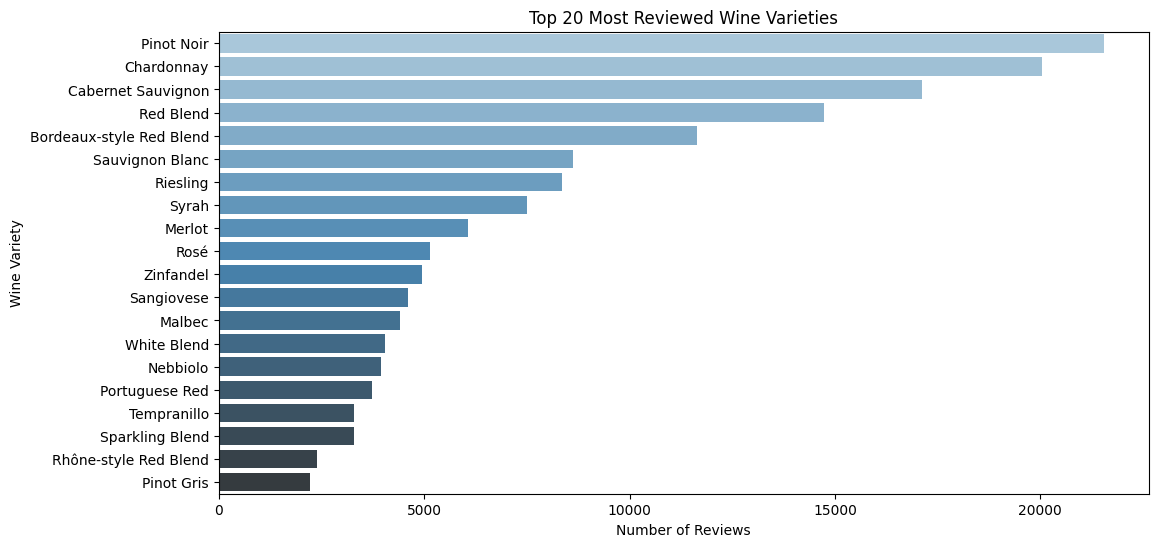

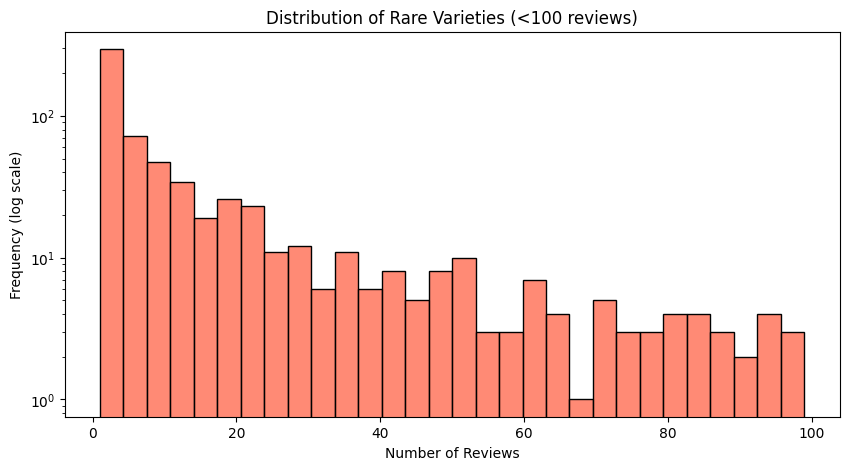

In [33]:
# predict wine variety using structured & unstructured features
variety_counts = df['variety'].value_counts()

# plot top 20 most reviewed varieties.
# take up most of the wine reviews, so not a very even distribution of wine reviews, so accuracy is difficult to improve
plt.figure(figsize=(12, 6))
sns.barplot(x=variety_counts.head(20).values, y=variety_counts.head(20).index, palette='Blues_d')
plt.title('Top 20 Most Reviewed Wine Varieties')
plt.xlabel('Number of Reviews')
plt.ylabel('Wine Variety')
plt.show()

# plot long tail of rare varieties
rare_varieties = variety_counts[variety_counts < 100]

plt.figure(figsize=(10, 5))
sns.histplot(rare_varieties.values, bins=30, log=True, color='tomato')
plt.title('Distribution of Rare Varieties (<100 reviews)')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency (log scale)')
plt.show()

# Associations

## Wine Characteristic and Country

In [34]:
# clean and preprocess descriptions
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    return text

# apply cleaning
df['clean_description'] = df['description'].dropna().apply(clean_text)

# pick top N countries
top_countries = df['country'].value_counts().head(5).index.tolist()

# subset to top countries only
df_top = df[df['country'].isin(top_countries)].copy()

# group descriptions by country
grouped = df_top.groupby('country')['clean_description'].apply(lambda x: ' '.join(x)).reset_index()

# custom stopwords: combine sklearn's, WordCloud's, and domain-specific
custom_stopwords = set(ENGLISH_STOP_WORDS).union({
    "wine", "wines", "flavors", "aroma", "palate", "note", "notes", "nose", "finish",
    "taste", "hint", "mouth", "feel", "tastes", "shows", "aromas", "theres", "drink",
    "now", "medium", "style", "good", "like", 'feels', 'offers', 'tannins', 'black'
})


# TF-IDF Vectorizer with custom stopwords
# Convert the set of custom stopwords to a list
# Convert stopwords set to list
tfidf = TfidfVectorizer(stop_words=list(custom_stopwords), max_features=1000)

# Fit and transform
tfidf_matrix = tfidf.fit_transform(grouped['clean_description'])


# Convert to DataFrame for easier handling
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=grouped['country'], columns=tfidf.get_feature_names_out())

# Get top N words per country
def get_top_n_words(country, n=10):
    top_words = tfidf_df.loc[country].sort_values(ascending=False).head(n)
    return top_words

# Example: Top 10 words for each top country
for country in top_countries:
    print(f"\nTop words for {country}:")
    print(get_top_n_words(country, n=5))


Top words for US:
fruit      0.369508
cherry     0.264992
acidity    0.221800
oak        0.213458
dry        0.207293
Name: US, dtype: float64

Top words for France:
acidity    0.391576
fruit      0.349307
ripe       0.307743
fruits     0.250318
rich       0.197903
Name: France, dtype: float64

Top words for Italy:
fruit     0.362687
cherry    0.325854
spice     0.241590
white     0.181567
berry     0.171755
Name: Italy, dtype: float64

Top words for Spain:
berry     0.327466
plum      0.315667
fruit     0.224523
cherry    0.190152
apple     0.170402
Name: Spain, dtype: float64

Top words for Portugal:
acidity    0.395970
ripe       0.305337
fruit      0.295744
fruits     0.280578
rich       0.225942
Name: Portugal, dtype: float64


In [35]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

# clean text function
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    return text

# apply cleaning
df['clean_description'] = df['description'].dropna().apply(clean_text)

# pick top 10 regions
top_regions = df['region_1'].value_counts().head(5).index.tolist()

# subset to top regions only
df_top_regions = df[df['region_1'].isin(top_regions)].copy()

# group descriptions by region
grouped_regions = df_top_regions.groupby('region_1')['clean_description'].apply(lambda x: ' '.join(x)).reset_index()

# custom stopwords
custom_stopwords = set(ENGLISH_STOP_WORDS).union({
    "wine", "wines", "flavors", "aroma", "palate", "note", "notes", "nose", "finish",
    "taste", "hint", "mouth", "feel", "tastes", "shows", "aromas", "theres", "drink",
    "now", "medium", "style", "good", "like", 'feels', 'offers', 'tannins', 'black'
})

# TF-IDF Vectorizer with custom stopwords
tfidf = TfidfVectorizer(stop_words=list(custom_stopwords), max_features=1000)

# Fit and transform
tfidf_matrix_regions = tfidf.fit_transform(grouped_regions['clean_description'])

# Convert to DataFrame
tfidf_df_regions = pd.DataFrame(tfidf_matrix_regions.toarray(), index=grouped_regions['region_1'], columns=tfidf.get_feature_names_out())

# Map each region to its most common country
region_to_country = df_top_regions.groupby('region_1')['country'].agg(lambda x: x.value_counts().idxmax()).to_dict()

# Function to get top N words per region
def get_top_n_words_region(region, n=10):
    top_words = tfidf_df_regions.loc[region].sort_values(ascending=False).head(n)
    return top_words

# Example: Print top 5 words for each top region + its country
for region in top_regions:
    country = region_to_country.get(region, 'Unknown')
    print(f"\nTop words for {region} ({country}):")
    print(get_top_n_words_region(region, n=5))



Top words for Napa Valley (US):
oak           0.325293
cabernet      0.268652
dry           0.228709
fruit         0.222504
blackberry    0.217652
Name: Napa Valley, dtype: float64

Top words for Columbia Valley (WA) (US):
fruit       0.555136
cabernet    0.227973
blend       0.209164
cherry      0.203395
merlot      0.145085
Name: Columbia Valley (WA), dtype: float64

Top words for Russian River Valley (US):
acidity    0.323204
oak        0.282640
cherry     0.270676
fruit      0.240206
dry        0.210858
Name: Russian River Valley, dtype: float64

Top words for California (US):
dry        0.302974
sweet      0.301999
cherry     0.236919
acidity    0.227657
fruit      0.225219
Name: California, dtype: float64

Top words for Mendoza (Argentina):
berry         0.399095
plum          0.270860
fruit         0.248307
blackberry    0.220383
malbec        0.181504
Name: Mendoza, dtype: float64


## Wine Variety and Country

variety    Abouriou  Aglianico  Airen  Albana  Albanello  Albariño  Albarossa  \
country                                                                         
Argentina         0          0      0       0          0         0          0   
Australia         0          0      0       0          0         0          0   
Austria           0          0      0       0          0         0          0   
Chile             0          0      0       0          0         0          0   
France            2          0      0       0          0         0          0   
Germany           0          0      0       0          0         0          0   
Italy             0        575      0      35          1         0          2   
Portugal          0          0      0       1          0         0          0   
Spain             0          0      6       0          0       618          0   
US                1         22      0       0          0       174          0   

variety    Albarín  Aleatic

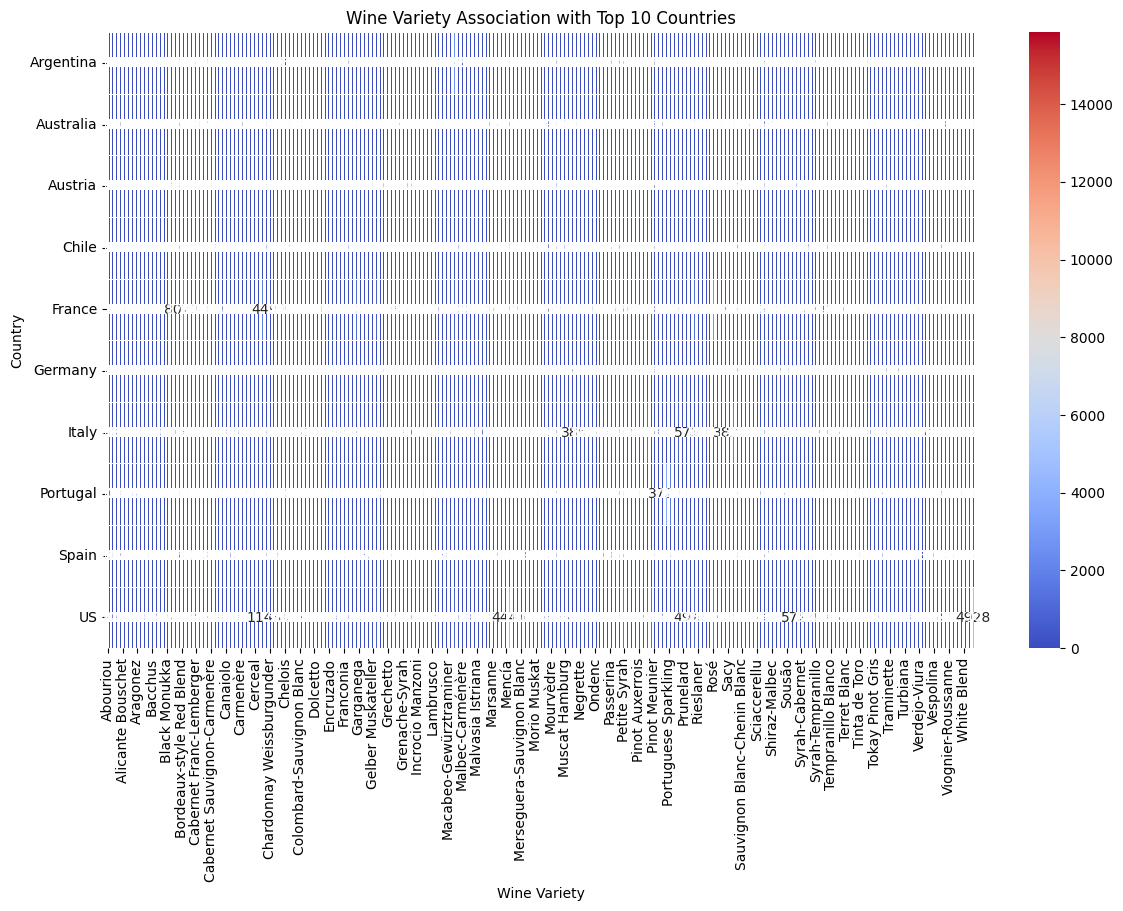

variety    Bordeaux-style Red Blend  Cabernet Sauvignon  Chardonnay  Merlot  \
country                                                                       
Argentina                       148                1020         562     161   
Australia                        78                 674         769      80   
Austria                           7                   9          88       6   
Chile                            74                1440         974     522   
France                         8023                  89        4497     190   
Germany                           0                   1           7       0   
Italy                             7                 263         616     311   
Portugal                          8                  28          24      20   
Spain                            17                  96         109      31   
US                             2928               12868       11434    4446   

variety    Pinot Noir  Red Blend  Riesling  Rosé  S

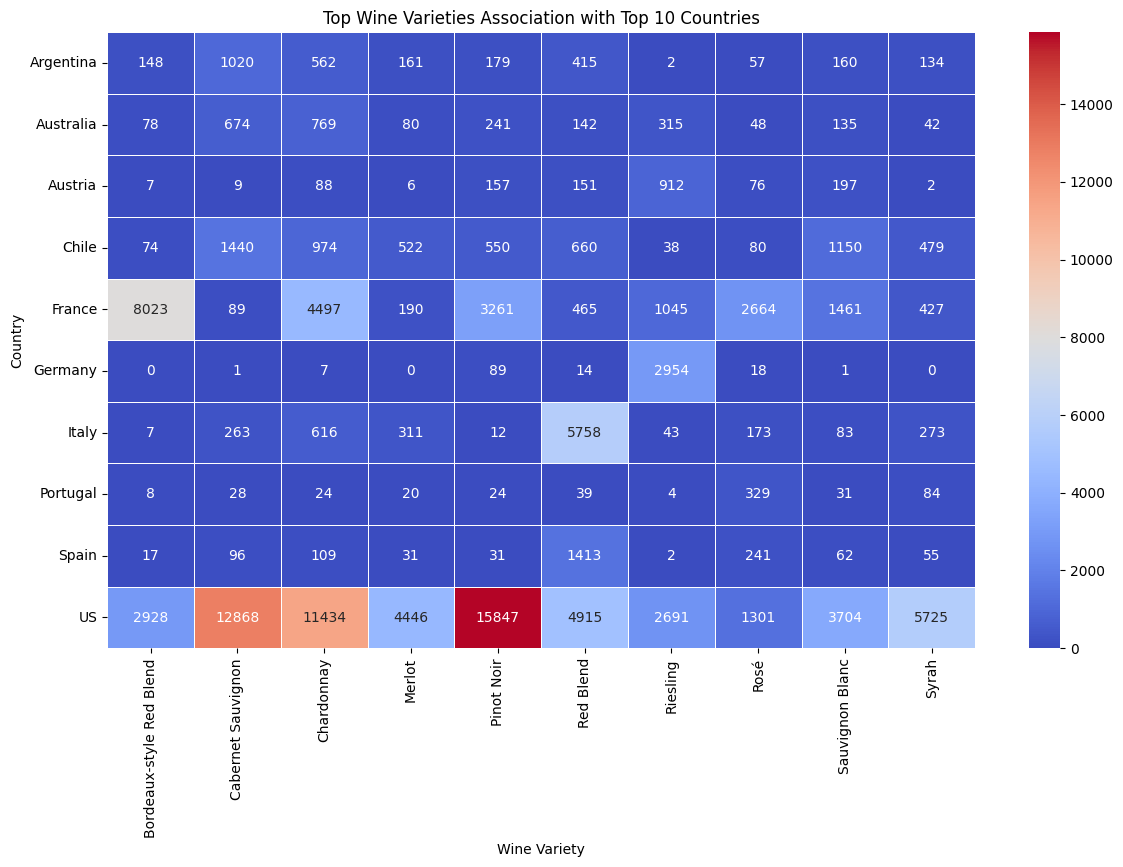

In [36]:
# Get the top 10 countries based on frequency in the dataset
top_10_countries = df['country'].value_counts().head(10).index.tolist()

# Subset the DataFrame to include only the top 10 countries
df_top_10 = df[df['country'].isin(top_10_countries)]

# Group by country and variety, then count occurrences
country_variety_counts = df_top_10.groupby(['country', 'variety']).size().unstack(fill_value=0)

# Display the country-variety association table
print(country_variety_counts)

# Create a heatmap to visualize the association between country and wine variety
plt.figure(figsize=(14, 8))
sns.heatmap(country_variety_counts, annot=True, cmap='coolwarm', fmt='d', linewidths=0.5)
plt.title('Wine Variety Association with Top 10 Countries')
plt.xlabel('Wine Variety')
plt.ylabel('Country')
plt.show()

# Get the top 10 most frequent wine varieties
top_varieties = df['variety'].value_counts().head(10).index.tolist()

# Subset the DataFrame to include only the top 10 countries and the top wine varieties
df_top_varieties = df[df['country'].isin(top_10_countries) & df['variety'].isin(top_varieties)]

# Group by country and variety, then count occurrences
country_variety_counts_top = df_top_varieties.groupby(['country', 'variety']).size().unstack(fill_value=0)

# Display the country-variety association table
print(country_variety_counts_top)

# Create a heatmap to visualize the association between country and wine variety
plt.figure(figsize=(14, 8))
sns.heatmap(country_variety_counts_top, annot=True, cmap='coolwarm', fmt='d', linewidths=0.5)
plt.title('Top Wine Varieties Association with Top 10 Countries')
plt.xlabel('Wine Variety')
plt.ylabel('Country')
plt.show()
